### 0.导入函数库

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from obspy.core import read
from obspy import UTCDateTime
from obspy import Stream
from obspy import read_events
from obspy import read_inventory
from obspy.signal.trigger import recursive_sta_lta, plot_trigger
from obspy.signal.trigger import coincidence_trigger
from obspy.signal.trigger import aic_simple
from obspy.signal.cross_correlation import correlation_detector
from utilities.plot_event import plot_picked
import matplotlib
import warnings
warnings.filterwarnings("ignore")
matplotlib.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': False,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            # Use ASCII minus
                            'axes.unicode_minus': False,
                            })

def extract_detections(tr, detection_times, pre_detection=10, post_detection=100):
    detections = []
    for detection in detection_times:
        detections.append(
            tr.slice(detection - pre_detection, 
                     detection + post_detection).copy())
    return detections

### 1.地震触发检测

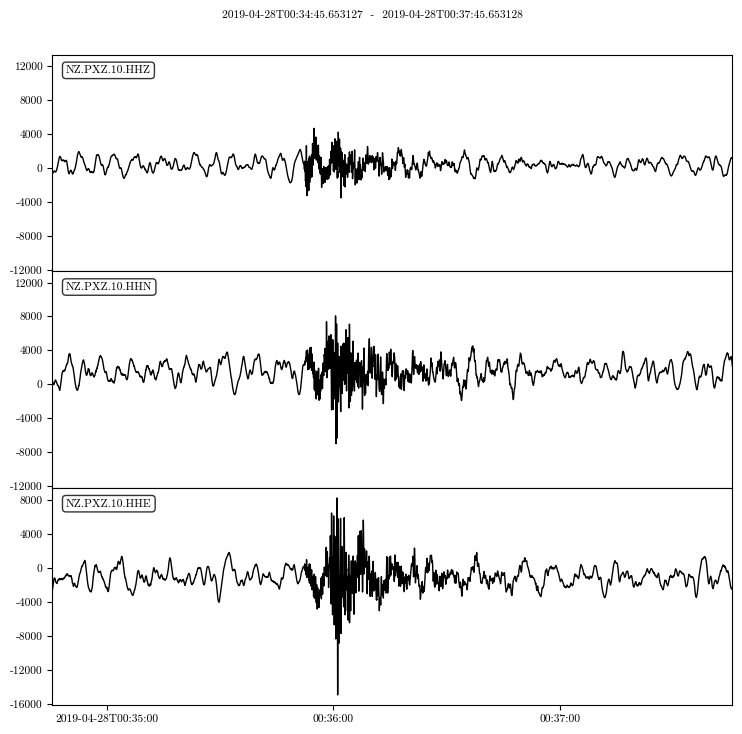

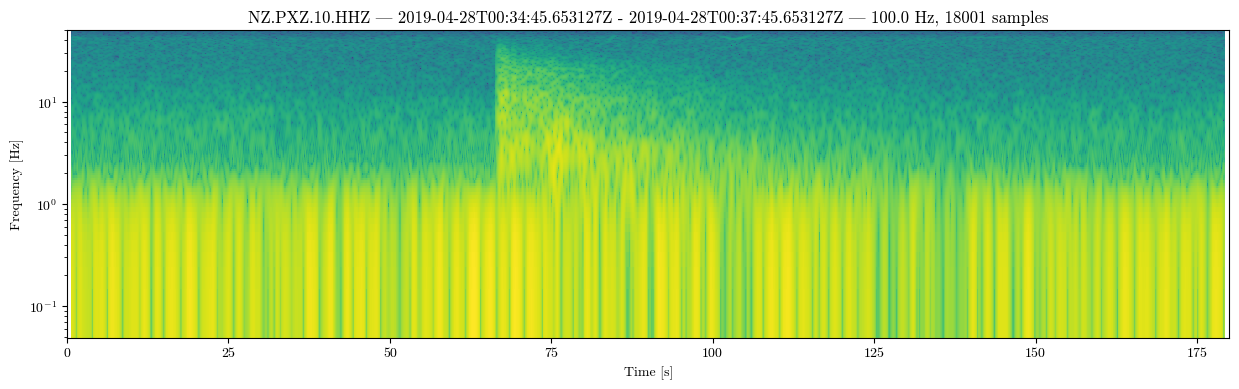

In [123]:
st = read("../data/event_NZ_PXZ.mseed")

starttime = UTCDateTime(2019, 4, 28)
endtime = starttime + 86400

geonet_catalog = read_events("../data/geonet_catalog.xml")
# fig = geonet_catalog.plot(projection="local", resolution="h")

event = geonet_catalog[0]

event_st = st.slice(
    event.preferred_origin().time - 60,
    event.preferred_origin().time + 120).copy()
fig = event_st.plot(handle=True)
fig = event_st.select(component="Z").spectrogram(dbscale=True, log=True)
plt.show()

***(1)根据瞬时谱选择滤波频段***
```
可以看到在 P 波的开始时，2Hz以上的频率增加了。地球的噪声在低频段是占主导地位的。尝试对数据进行高通滤波，以使地震相更加清晰。需要记住的是，滤波会改变数据的相位，因此这会影响我们对地震相到达时间的估计... 这是在后续进行相位拾取时需要注意
```

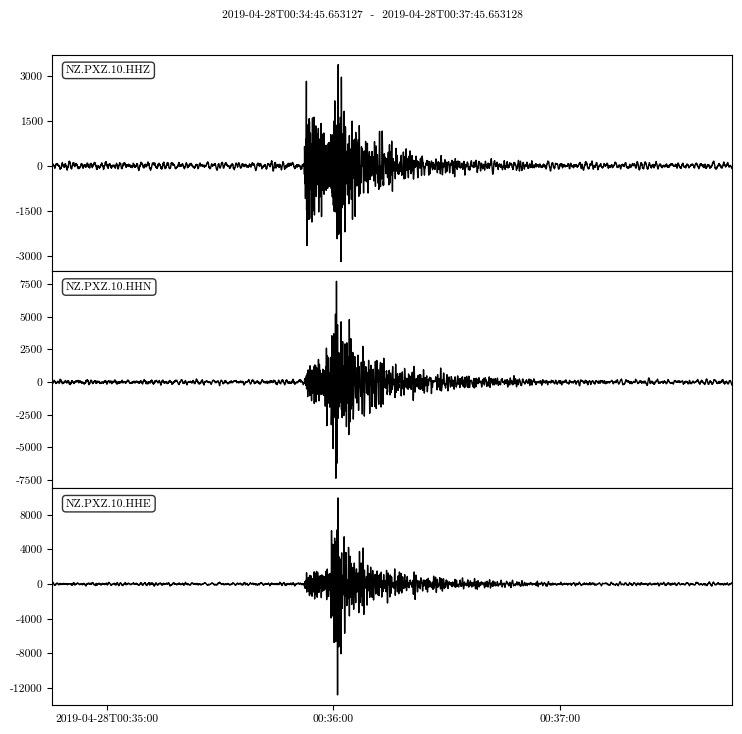

In [61]:
filtered = event_st.copy().detrend().filter("highpass", freq=1.5, corners=2)
fig = filtered.plot(equal_scale=False, handle=True)
plt.show()

***(2)STA/LTA事件检测***

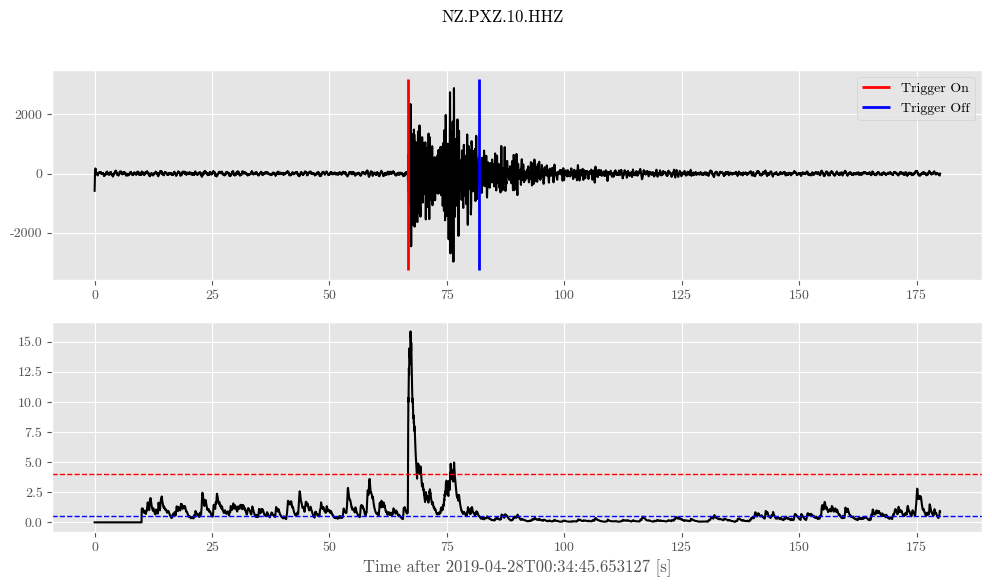

In [45]:
tr = event_st.select(component="Z")[0]
tr = tr.copy().filter("highpass", freq=2, corners=2)
detector = recursive_sta_lta(
    tr.data, 
    nsta=int(0.5 * tr.stats.sampling_rate), 
    nlta=int(10 * tr.stats.sampling_rate))
plt.rcParams['figure.figsize'] = 12, 6
fig = plot_trigger(tr, detector, thr_on=4, thr_off=0.5)

***(3)多台事件检测***
```
生成一个触发器列表：这里没有使用显式的重新触发时间限制，使用了次要阈值。只有在至少3个台站上触发（由thr_coincidence_sum设置），才会判断为一个地震事件触发。
```

Found 14 triggers
{'time': UTCDateTime(2019, 4, 28, 0, 29, 13, 903127), 'stations': ['PXZ', 'KAHZ', 'WPHZ', 'PRHZ'], 'trace_ids': ['NZ.PXZ.10.HHZ', 'NZ.KAHZ.10.EHZ', 'NZ.WPHZ.10.EHZ', 'NZ.PRHZ.10.EHZ'], 'coincidence_sum': 4.0, 'similarity': {}, 'duration': 8.375264167785645}
{'time': UTCDateTime(2019, 4, 28, 0, 35, 48, 258391), 'stations': ['PRHZ', 'WPHZ', 'PXZ', 'KAHZ'], 'trace_ids': ['NZ.PRHZ.10.EHZ', 'NZ.WPHZ.10.EHZ', 'NZ.PXZ.10.HHZ', 'NZ.KAHZ.10.EHZ'], 'coincidence_sum': 4.0, 'similarity': {}, 'duration': 15.394739866256714}
{'time': UTCDateTime(2019, 4, 28, 0, 40, 18, 43131), 'stations': ['WPHZ', 'PRHZ', 'PXZ', 'KAHZ'], 'trace_ids': ['NZ.WPHZ.10.EHZ', 'NZ.PRHZ.10.EHZ', 'NZ.PXZ.10.HHZ', 'NZ.KAHZ.10.EHZ'], 'coincidence_sum': 4.0, 'similarity': {}, 'duration': 10.415260076522827}
{'time': UTCDateTime(2019, 4, 28, 2, 32, 28, 828391), 'stations': ['PRHZ', 'PXZ', 'WPHZ', 'KAHZ'], 'trace_ids': ['NZ.PRHZ.10.EHZ', 'NZ.PXZ.10.HHZ', 'NZ.WPHZ.10.EHZ', 'NZ.KAHZ.10.EHZ'], 'coincidence_sum': 4.0

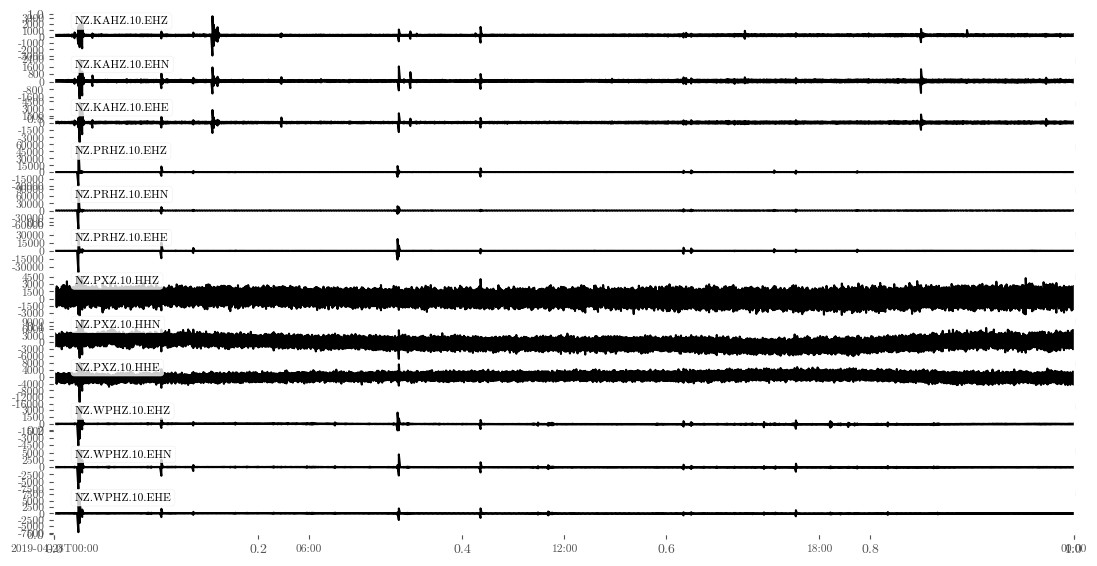

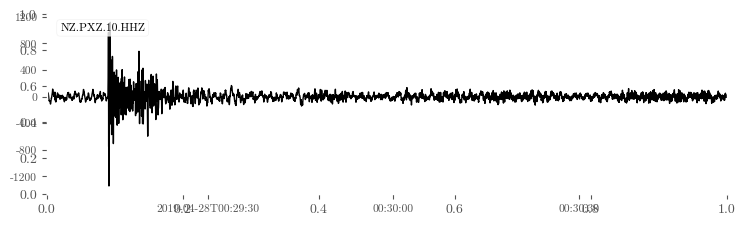

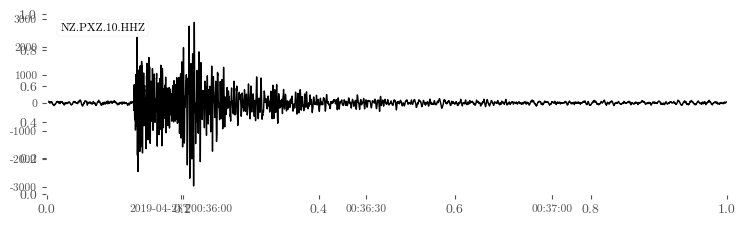

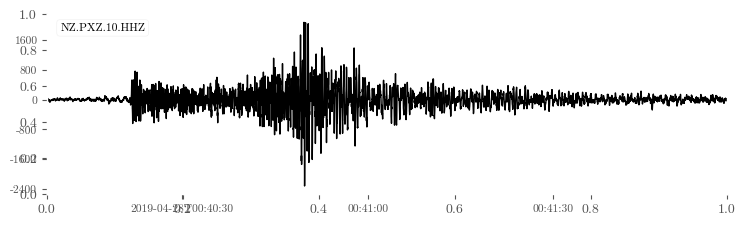

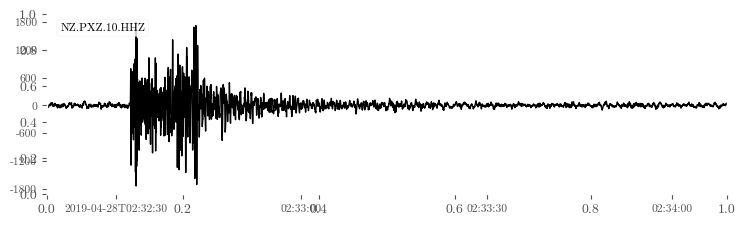

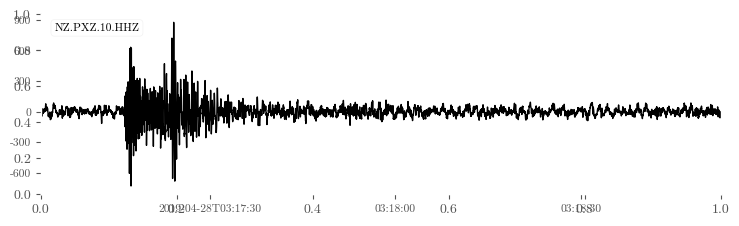

In [49]:
st = read("../data/event_20190428.mseed")
fig, ax = plt.subplots()
fig = st.plot(equal_scale=False, size=(800, 750), fig=fig)

st.filter("highpass", freq=2, corners=2)
st2 = st.select(component="Z") # It is normal to just use the

trig = coincidence_trigger(
    "recstalta", thr_on=7.0, thr_off=1, 
    stream=st2, thr_coincidence_sum=3, sta=0.5, lta=10)
print("Found {0} triggers".format(len(trig)))
for t in trig:
    print(t)

plt.rcParams['figure.figsize'] = 8, 3
tr = st.select(station="PXZ", component="Z")[0]
detections = extract_detections(tr, [t['time'] for t in trig])
for detection in detections[0:5]:
    fig, ax = plt.subplots()
    fig = detection.plot(fig=fig)
plt.show()

***(4)匹配滤波检测***

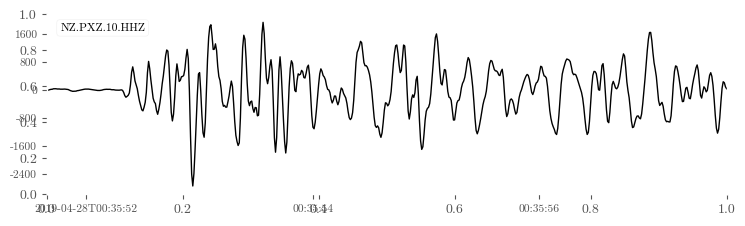

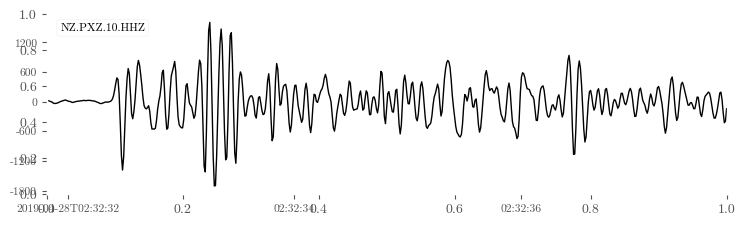

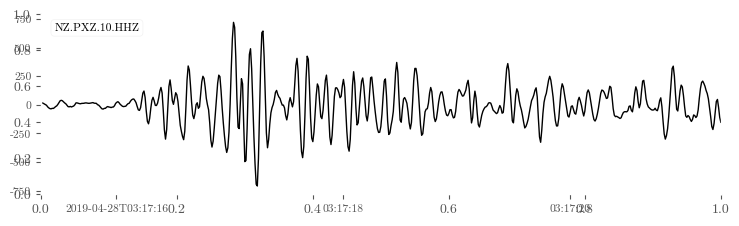

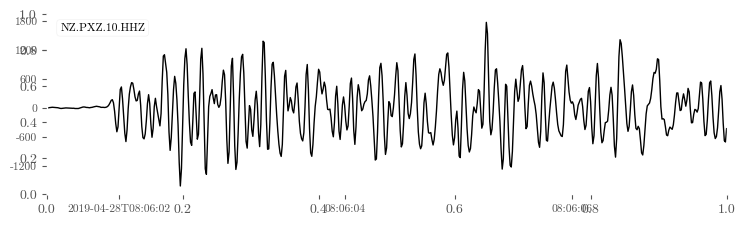

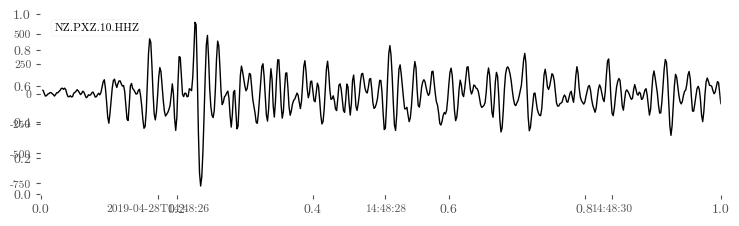

In [50]:
# 创建匹配模板
tr = st.select(station="PXZ", component="Z")[0]
filtered = tr.copy().detrend().filter("highpass", freq=2, corners=2)
geonet_times = [e.preferred_origin().time for e in geonet_catalog]
templates = extract_detections(
    tr=filtered, detection_times=geonet_times, pre_detection=-6, 
    post_detection=12)

for template in templates[0:5]:
    fig, ax = plt.subplots()
    fig = template.plot(fig=fig)
plt.show()

Made 26 detections from 9 templates


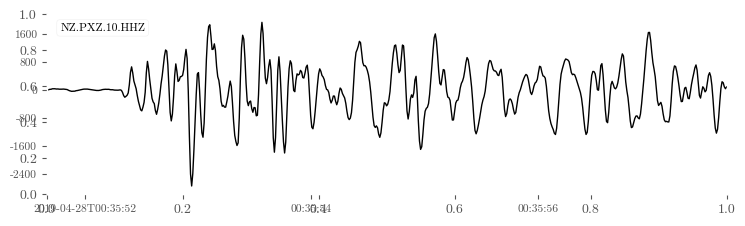

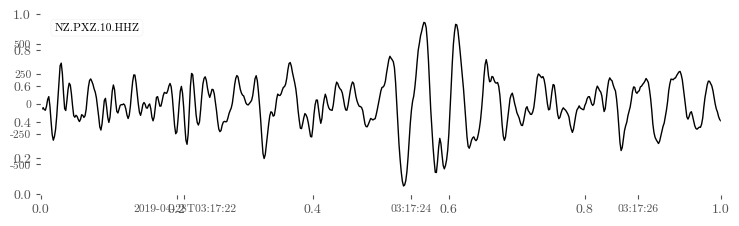

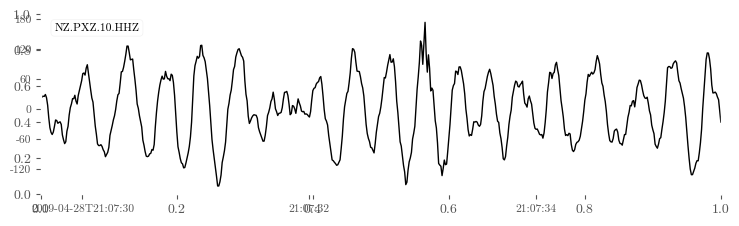

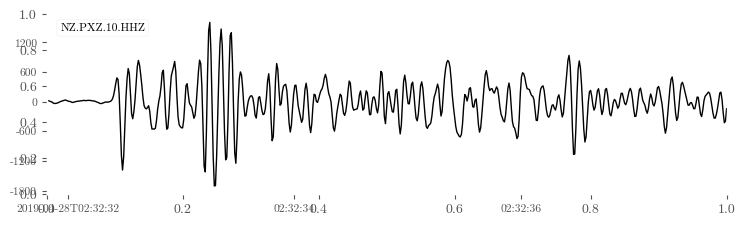

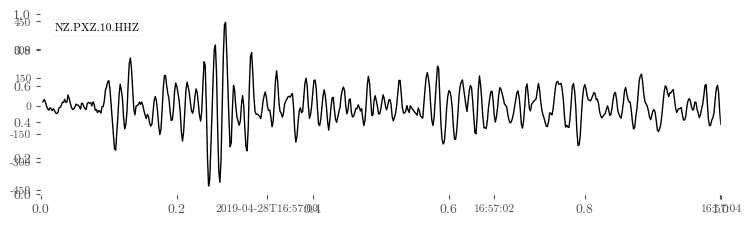

In [51]:
# 使用相关检测器
threshold = 0.4  
trig_off_time = 2.0

stream = Stream([tr])
template_streams = [Stream([template]) for template in templates]

detections = []
for template in template_streams:
    dets, _ = correlation_detector(
        stream=stream, templates=[template], heights=threshold, 
        distance=trig_off_time)
    detections.extend(dets)
print("Made {0} detections from {1} templates".format(
    len(detections), len(templates)))

detection_waveforms = extract_detections(
    tr=filtered, pre_detection=0, post_detection=6,
    detection_times=[d["time"] for d in detections])
for d in detection_waveforms[0:5]:
    fig, ax = plt.subplots()
    fig = d.plot(fig=fig)
plt.show()

### 2.震相到时检测

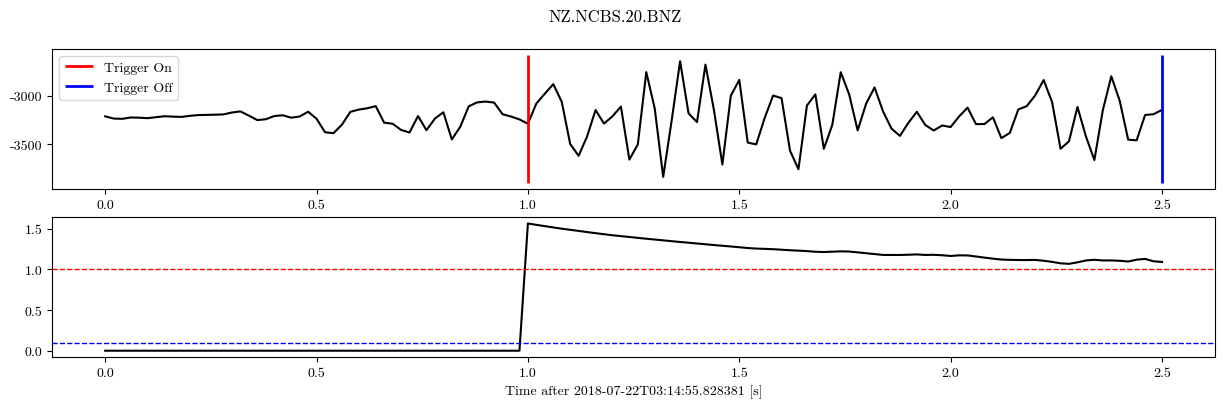

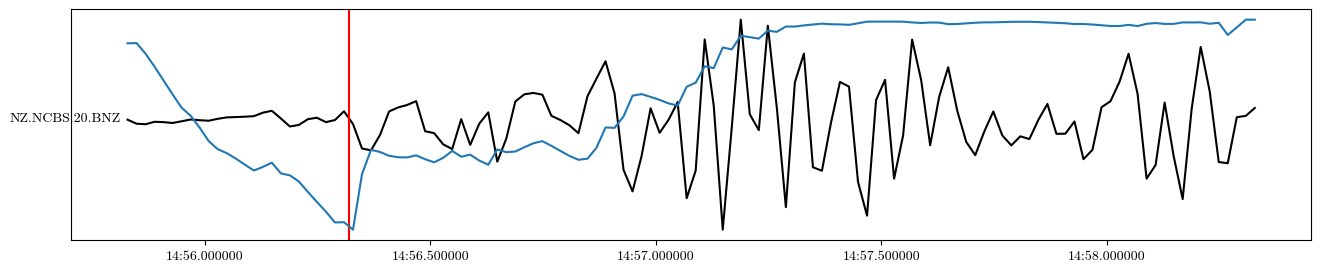

In [122]:
event = read_events("../data/geonet_2018_catalog.xml")[0]
st = read("../data/gonet_events.mseed")

# 按到时排序
event.picks.sort(key=lambda p: p.time)
# 选择第一道道波形
first_stations = {p.waveform_id.station_code for p in event.picks[0:1]}
event.picks = [p for p in event.picks if p.waveform_id.station_code in first_stations]
short_st = Stream()
for pick in event.picks:
    if pick.phase_hint[0].upper() != "P":
        continue
    tr = st.select(id=pick.waveform_id.get_seed_string())
    tr = tr.slice(pick.time - 0.5, pick.time + 2).copy()
    short_st += tr
short_st.merge().sort(["starttime"])

# STA/LTA触发检测
tr = st.select(id=pick.waveform_id.get_seed_string())[0]
detector = recursive_sta_lta(
    tr.data, 
    nsta=int(0.2 * tr.stats.sampling_rate), 
    nlta=int(1 * tr.stats.sampling_rate))
detector = detector[0:short_st[0].data.size]
_ = plot_trigger(short_st[0], detector, thr_on=1, thr_off=0.1)

# 使用AIC方法检测震相到时
aic = aic_simple(short_st[0].data)
std = short_st[0].data
aic_normalized = (aic - np.min(aic)) / (np.max(aic) - np.min(aic))
std_normalized = (std - np.min(std)) / (np.max(std) - np.min(std))

# 绘图
pick_color = {'P': 'r', 'S': 'b'}
st = short_st.copy()    
fig, axes = plt.subplots(nrows=len(st), figsize=(16, 3), sharex=True)
axes = np.atleast_1d(axes)

for tr, ax in zip(st, axes):
    x = np.arange(0, tr.stats.npts)
    x = x * tr.stats.delta
    x = [(tr.stats.starttime + _).datetime for _ in x]
    ax.plot(x, std_normalized, 'k')
    ax.set_ylabel(tr.id, rotation=0)
    ax.set_yticks([])
    for pick in event.picks:
        if pick.waveform_id.get_seed_string() == tr.id:
            if x[0] < pick.time.datetime < x[-1]:
                ax.axvline(x=pick.time.datetime,
                            color=pick_color[pick.phase_hint])
#fig.subplots_adjust(wspace=0, hspace=0)

ax.plot(x, aic_normalized )

plt.show()

### 3.AI地震识别
1. 震相识别 
phaseNet、 EQTransform
2. 震相关联
phaseLink